# Création de la base de donnée sous Neo4j

## Importation des librairies

In [5]:
pip install py2neo

  Using cached py2neo-2021.2.3-py2.py3-none-any.whl (177 kB)
  Using cached interchange-2021.0.4-py2.py3-none-any.whl (28 kB)
  Using cached monotonic-1.6-py2.py3-none-any.whl (8.2 kB)
  Using cached pansi-2020.7.3-py2.py3-none-any.whl (10 kB)
Note: you may need to restart the kernel to use updated packages.


In [369]:
import numpy as np 
import pandas as pd
from py2neo import Graph
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import time
import math

## Chargement des données

In [370]:
df = pd.read_csv('netflix_titles.csv')
df["date_added"] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day

## Se connecter à Neo4J 
pour lancer la sandbox il faut aller sur ce site : https://sandbox.neo4j.com/
ensuite il faut chercher dans une database un onglet connection details, mais on peut
également le réaliser en local en cherchant les mêmes propriétés dans son neo desktop

In [371]:
ip="localhost" #ip address
port="7687" #bolt port
pwd="azert" #password
graph = Graph("bolt://"+ip+":"+port, auth=("neo4j", pwd))

In [372]:
LOAD_DATA = False

def run_request(request,LOAD_DATA=False):
    print("run")
    if (LOAD_DATA):
        start_time = time.time()
        print(graph.run(request)) 
        exec_time = time.time() - start_time
        print(f'-- {exec_time} seconds --')

## Suppression des nodes et relations

In [373]:
request_delete ="""
MATCH (n) DETACH DELETE n;
"""
run_request(request_delete,LOAD_DATA)

run


## Creation des nodes

In [374]:
request ="""
CREATE (m:Movie {id: $show_id})
SET
m.title = $title,
m.director = $director,
m.country = $country,
m.date_str = $date_added, 
m.release_year = $release_year,
m.rating = $rating,
m.duration = $duration ,
m.listed_in = $listed_in ,
m.description = $description,
m.cast=$cast,
m.year = $year,
m.month = $month,
m.day = $day,
m.type = $type_movie
"""
start_time = time.time()
count=df.shape[0]
if (LOAD_DATA):
    for index, row in df.iterrows():
        graph.run(request,
                  show_id=row['show_id'],
                  title=None if pd.isnull(row['title']) else row['title'],
                  director=None if pd.isnull(row['director']) else row['director'],
                  country=None if pd.isnull(row['country']) else row['country'],
                  date_added= None if pd.isnull(row['date_added']) else row['date_added'].strftime('%Y-%m-%d'),
                  release_year=None if pd.isnull(row['release_year']) else row['release_year'],
                  rating=None if pd.isnull(row['rating']) else row['rating'],          
                  duration=None if pd.isnull(row['duration']) else row['duration'],
                  listed_in=None if pd.isnull(row['listed_in']) else row['listed_in'],
                  description=None if pd.isnull(row['description']) else row['description'],
                  cast= None if pd.isnull(row['cast']) else row['cast'],
                  year=None if pd.isnull(row['year']) else row['year'],
                  month=None if pd.isnull(row['month']) else row['month'],
                  day=None if pd.isnull(row['day']) else row['day'],
                  type_movie=None if pd.isnull(row['type']) else row['type']
                  )

In [375]:
# CREATE  PERSONS
request ="""
MATCH (m:Movie)
WHERE m.cast IS NOT NULL
WITH m
UNWIND split(m.cast, ', ') AS actor
MERGE (p:Person {name: trim(actor)})
MERGE (p)-[r:ACTED_IN]->(m);
"""    
run_request(request,LOAD_DATA)

run


In [376]:
# CREATE CATEGORIES    
request ="""    
MATCH (m:Movie)
WHERE m.listed_in IS NOT NULL
WITH m
UNWIND split(m.listed_in, ',') AS category
MERGE (c:Category {name: trim(category)})
MERGE (m)-[r:IN_CATEGORY]->(c);
"""    
run_request(request,LOAD_DATA)

run


In [377]:
# CREATE TYPE
request =""" 
MATCH (m:Movie)
WHERE m.type IS NOT NULL
WITH m
MERGE (t:Type {type: m.type})
MERGE (m)-[r:TYPED_AS]->(t);
"""
run_request(request,LOAD_DATA) 

run


In [378]:
# CREATE DIRECTOR
request =""" 
MATCH (m:Movie)
WHERE m.director IS NOT NULL
WITH m
UNWIND split(m.director, ', ') AS director
MERGE (d:Person {name: m.director})
MERGE (d)-[r:DIRECTED]->(m);
"""
run_request(request,LOAD_DATA) 

run


In [379]:
# CREATE COUNTRIES
request =""" 
MATCH (m:Movie)
WHERE m.country IS NOT NULL
MERGE (c:Country {name: trim(m.country)})
MERGE (m)-[:WHERE]->(c);
"""
run_request(request,LOAD_DATA) 

run


In [380]:
# DELETE UNUSED PROPERTY
request="""
MATCH(m:Movie)
SET m.country = null, m.category = null,m.type = null , m.director = null , m.cast =null
"""
run_request(request,LOAD_DATA) 

run


In [381]:
# BUILD THE WORK_WITH RELATIONSHIP => beaucoup trop long
#request = """
#MATCH (p:Person)-[rel:ACTED_IN]->(m:Movie)<-[:ACTED_IN]-(p2:Person)
#MERGE (p)-[r:WORK_WITH]-(p2);
#"""
#run_request(request,LOAD_DATA)

In [382]:
# Create Time Tree Index
request="""
CREATE INDEX ON :Year(value);
"""
run_request(request,LOAD_DATA)

run


In [383]:
# Create Years
request="""
WITH range(2012, 2019) AS years, range(1,12) AS months
FOREACH(year IN years |
  CREATE (y:Year {value: year}));
"""
run_request(request,LOAD_DATA)

run


In [384]:
# Connect Years Sequentially
request="""
MATCH (year:Year)
WITH year
ORDER BY year.value
WITH collect(year) AS years
FOREACH(i in RANGE(0, size(years)-2) |
    FOREACH(year1 in [years[i]] |
        FOREACH(year2 in [years[i+1]] |
            MERGE (year1)-[:NEXT]->(year2))));
"""
run_request(request,LOAD_DATA)

run


In [385]:
request="""
MATCH (m:Movie)
WITH m, m.year AS y
MATCH (year:Year {value: y})
MERGE (m)-[:CREATED_ON]->(year)
RETURN m,year;
"""
run_request(request,LOAD_DATA)

run


In [386]:
# Nodes Cardinalities
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

nodes_df

,label,count
0,Movie,6234
1,Person,30421
2,Category,42
3,Type,2
4,Country,554
5,Year,8


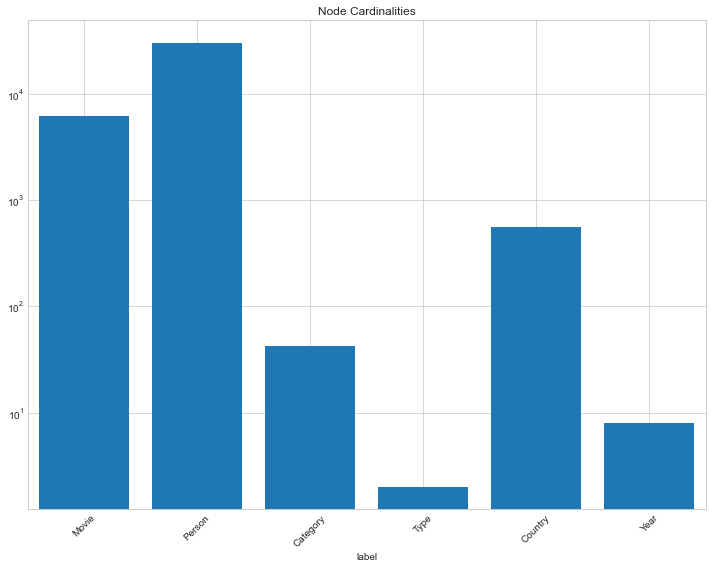

In [387]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities",figsize=(10,8))
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.bar(nodes_df['label'],nodes_df['count'])
plt.show()

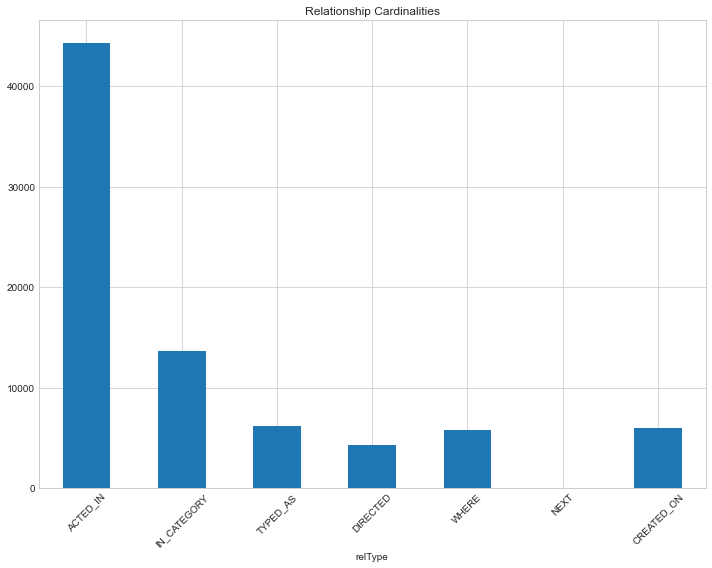

In [388]:
# Relations Ship Cardinalities
result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities",figsize=(10,8))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [389]:
request_top_5_actor="""
MATCH (p:Person)-[rel:ACTED_IN]->(m:Movie)
WITH p,collect(m.title) as movies,count(*) as total
RETURN  p.name, movies,total
ORDER BY total DESC
LIMIT 5
"""
graph.run(request_top_5_actor).to_data_frame().head()

,p.name,movies,total
0,Anupam Kher,"[Wake Up Sid, A Wednesday, Zokkomon, C Kkompan...",33
1,Shah Rukh Khan,[My Next Guest with David Letterman and Shah R...,30
2,Om Puri,"[Delhi 6, Kismat Konnection, Kurbaan, Chaar Sa...",27
3,Naseeruddin Shah,"[Hope Aur Hum, Main, Meri Patni Aur Woh, SunGa...",27
4,Yuki Kaji,"[DRAGON PILOT: Hisone & Masotan, Berserk: The ...",26


In [390]:
request_movies_actors_witcher = """
MATCH (p:Person)-[rel:ACTED_IN]->(m:Movie) 
WHERE m.title = 'The Witcher'
RETURN p.name, m.title
"""
graph.run(request_movies_actors_witcher).to_data_frame()

,p.name,m.title
0,Eamon Farren,The Witcher
1,Joey Batey,The Witcher
2,Anna Shaffer,The Witcher
3,Adam Levy,The Witcher
4,Lars Mikkelsen,The Witcher
5,Mimi Ndiweni,The Witcher
6,Anya Chalotra,The Witcher
7,MyAnna Buring,The Witcher
8,Wilson Radjou-Pujalte,The Witcher
9,Jodhi May,The Witcher


In [391]:
request_movies_actor = """
MATCH (p:Person)-[rel:ACTED_IN]->(m:Movie)<-[:ACTED_IN]-(p2:Person)
RETURN p.name, m.title, p2.name
"""
graph.run(request_movies_actor).to_data_frame()

,p.name,m.title,p2.name
0,Rishi Gambhir,Krish Trish and Baltiboy: Oversmartness Never ...,Deepak Chachra
1,Smita Malhotra,Krish Trish and Baltiboy: Oversmartness Never ...,Deepak Chachra
2,Deepak Chachra,Krish Trish and Baltiboy: Oversmartness Never ...,Rishi Gambhir
3,Smita Malhotra,Krish Trish and Baltiboy: Oversmartness Never ...,Rishi Gambhir
4,Deepak Chachra,Krish Trish and Baltiboy: Oversmartness Never ...,Smita Malhotra
...,...,...,...
417515,Baba Sehgal,Krish Trish and Baltiboy: Comics of India,Smita Malhotra
417516,Smita Malhotra,Krish Trish and Baltiboy: Comics of India,Damandeep Singh Baggan
417517,Baba Sehgal,Krish Trish and Baltiboy: Comics of India,Damandeep Singh Baggan
417518,Smita Malhotra,Krish Trish and Baltiboy: Comics of India,Baba Sehgal


# Connexion de la base de données sous Postgresql avec Python

In [392]:
pip install psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [393]:
import psycopg2

In [423]:
def connect():
    conn = psycopg2.connect(dbname='project', user='postgres',
                            host='localhost', password='azert')
    conn.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT)
    cursor = conn.cursor()
    return conn,cursor

In [424]:
#conn = psycopg2.connect("dbname='project' user='postgres' host='localhost' password='azert'")

In [425]:
#cur = conn.cursor()

# Tables principales

In [396]:
persons = """
match (p:Person)-[r]->(m:Movie)
return p.name, type(r)
"""
df_persons = graph.run(persons).to_data_frame()

In [397]:
df_persons.head()

,p.name,type(r)
0,Tilak Shetty,DIRECTED
1,Deepak Chachra,ACTED_IN
2,Rishi Gambhir,ACTED_IN
3,Smita Malhotra,ACTED_IN
4,Damandeep Singh Baggan,ACTED_IN


## Persons

### Traitement des directors

Il faut donc traiter ces cas dans le dataframe qui servira de source pour 
créer la table Personnes

In [404]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [405]:
def check_multiple_persons_names(df) :
    tab = []
    for i in range(len(df)) :
        s = df.loc[i, "p.name"]
        s = s.split(', ')
        tab.append(s)
    return flatten(tab)

In [406]:
def check_multiple_persons(df) :
    tab = []
    for i in range(len(df)) :
        s = df.loc[i, "p.name"]
        types = df.loc[i, "type(r)"]
        s = s.split(', ')
        for word in s :
            r = (word, types)
            tab.append(r)
    return tab

In [401]:
df_copy = df_persons.copy()

In [402]:
v = check_multiple_persons(df_copy)

In [403]:
names = []
jobs = []
for name, job in v :
    names.append(name)
    jobs.append(job)

In [49]:
df_persons_with_jobs = pd.DataFrame(data={'name' : names, 'jobs' : jobs})

In [50]:
df_person = pd.DataFrame(data={'name' : check_multiple_persons_names(df_copy)})

In [51]:
df_person = df_person.drop_duplicates()

In [52]:
df_person.head()

,name
0,Tilak Shetty
1,Deepak Chachra
2,Rishi Gambhir
3,Smita Malhotra
4,Damandeep Singh Baggan


In [53]:
df_table_persons = df_person.copy()

In [54]:
df_table_persons[['first_name','last_name']] = df_table_persons['name'].loc[df_table_persons['name'].str.split().str.len() == 2].str.split(expand=True)
df_table_persons = df_table_persons.drop(['name'], axis=1)

In [55]:
df_table_persons

,first_name,last_name
0,Tilak,Shetty
1,Deepak,Chachra
2,Rishi,Gambhir
3,Smita,Malhotra
4,NaN,NaN
...,...,...
49130,Thomas,Arnold
49131,Diana,Hardcastle
49133,NaN,NaN
49139,Jemima,West


In [56]:
x = df_table_persons.dropna(inplace=True)
if x != None :
    df_table_persons = x

In [57]:
df_table_persons = df_table_persons.reset_index(drop=True)

In [58]:
df_table_persons

,first_name,last_name
0,Tilak,Shetty
1,Deepak,Chachra
2,Rishi,Gambhir
3,Smita,Malhotra
4,Baba,Sehgal
...,...,...
27708,Diarmaid,Murtagh
27709,Michael,Jibson
27710,Thomas,Arnold
27711,Diana,Hardcastle


In [59]:
df_table_persons.to_csv('Persons.csv')

## Jobs

In [60]:
travails = """
match (p:Person)-[r]->(m:Movie)
return distinct type(r)
"""
df_travails = graph.run(travails).to_data_frame()

In [61]:
df_travails

,type(r)
0,DIRECTED
1,ACTED_IN


In [62]:
df_travailis = df_travails.rename(columns={"type(r)": "types"})

In [63]:
df_travails.to_csv('Jobs.csv')

## Countries

In [64]:
countries = """
match (c:Country)
return distinct c.name
"""
df_countries = graph.run(countries).to_data_frame()

In [65]:
df_countries

,c.name
0,"France, Belgium"
1,United States
2,"United States, Uruguay"
3,"United States,"
4,Thailand
...,...
549,"Cyprus, Austria, Thailand"
550,"United States, India, South Korea, China"
551,"Bulgaria, United States, Spain, Canada"
552,"United States, United Kingdom, Denmark, Sweden"


In [66]:
def check_multiple_countries(df) :
    tab = []
    for i in range(len(df)) :
        s = df.loc[i, "c.name"]
        s = s.split(',')
        tab.append(s)
    return flatten(tab)

In [67]:
def drop_empty_values(df):
    for row in range(len(df)) :
        s = df[row]
        if not s :
            print(row)
            df.drop(row, inplace = True)

In [68]:
df_countries = pd.DataFrame(data={'name' : check_multiple_countries(df_countries)})

In [69]:
df_countries = df_countries.name.str.strip()

In [70]:
x = df_countries.dropna(inplace=True)
if x != None :
    df_countries = x

In [71]:
df_countries = df_countries.reset_index(drop=True)

In [73]:
drop_empty_values(df_countries)

6
288
348


In [74]:
df_countries.head()

0           France
1          Belgium
2    United States
3    United States
4          Uruguay
Name: name, dtype: object

In [75]:
df_countries = df_countries.drop_duplicates()

In [76]:
df_countries = df_countries.reset_index(drop=True)

In [77]:
df_countries

0             France
1            Belgium
2      United States
3            Uruguay
4           Thailand
           ...      
105          Bermuda
106          Ecuador
107            Syria
108           Kuwait
109           Cyprus
Name: name, Length: 110, dtype: object

In [78]:
df_countries.to_csv('Countries.csv')

## Listed_in as categories

In [79]:
categories = """
match (c:Category)
return distinct c.name
"""
df_categories = graph.run(categories).to_data_frame()

In [80]:
df_categories.rename(columns={"c.name": "name"})

,name
0,Children & Family Movies
1,Cult Movies
2,Dramas
3,Independent Movies
4,Comedies
5,Romantic Movies
6,Action & Adventure
7,International Movies
8,Documentaries
9,Horror Movies


In [81]:
df_categories.to_csv('Categories.csv')

## Movies

In [407]:
request_movies = """
MATCH (m:Movie)
RETURN m.id, m.title, m.rating, m.release_year, m.date_str, m.year, m.day, m.month, m.description
"""
df_movies = graph.run(request_movies).to_data_frame()

In [409]:
df_movies.head()

,m.id,m.title,m.rating,m.release_year,m.date_str,m.year,m.day,m.month,m.description
0,80182597,Krish Trish and Baltiboy: Oversmartness Never ...,TV-Y7,2017,2017-09-08,2017.0,8.0,9.0,"A cat, monkey and donkey learn the consequence..."
1,80182481,Krish Trish and Baltiboy: Part II,TV-Y7,2010,2017-09-08,2017.0,8.0,9.0,Animal minstrels narrate stories about a monke...
2,80182621,Krish Trish and Baltiboy: The Greatest Trick,TV-Y7,2013,2017-09-08,2017.0,8.0,9.0,The consequences of trickery are explored in s...
3,80057969,Love,NR,2015,2017-09-08,2017.0,8.0,9.0,A man in an unsatisfying marriage recalls the ...
4,80060297,Manhattan Romance,TV-14,2014,2017-09-08,2017.0,8.0,9.0,A filmmaker working on a documentary about lov...


In [413]:
df_movies = df_movies.rename(columns={'m.id':'id', 'm.title':'title', 'm.rating':'rating', 'm.release_year':'release_year'
                  , 'm.date_str':'date_str', 'm.year':'year', 'm.day':'day', 'm.month':'month', 
                  'm.description':'description'})

In [414]:
df_movies.head()

,id,title,rating,release_year,date_str,year,day,month,description
0,80182597,Krish Trish and Baltiboy: Oversmartness Never ...,TV-Y7,2017,2017-09-08,2017.0,8.0,9.0,"A cat, monkey and donkey learn the consequence..."
1,80182481,Krish Trish and Baltiboy: Part II,TV-Y7,2010,2017-09-08,2017.0,8.0,9.0,Animal minstrels narrate stories about a monke...
2,80182621,Krish Trish and Baltiboy: The Greatest Trick,TV-Y7,2013,2017-09-08,2017.0,8.0,9.0,The consequences of trickery are explored in s...
3,80057969,Love,NR,2015,2017-09-08,2017.0,8.0,9.0,A man in an unsatisfying marriage recalls the ...
4,80060297,Manhattan Romance,TV-14,2014,2017-09-08,2017.0,8.0,9.0,A filmmaker working on a documentary about lov...


In [428]:
df_movies.to_csv('Movies.csv', index=False)

# Tables intermédiaires

## Movies et Actors

In [82]:
request_movies_actor = """
MATCH (p:Person)-[rel:ACTED_IN]->(m:Movie)
RETURN p.name, m.title, m.id
"""
df_ma = graph.run(request_movies_actor).to_data_frame()

In [83]:
df_ma.head()

,p.name,m.title,m.id
0,Deepak Chachra,Krish Trish and Baltiboy: Oversmartness Never ...,80182597
1,Rishi Gambhir,Krish Trish and Baltiboy: Oversmartness Never ...,80182597
2,Smita Malhotra,Krish Trish and Baltiboy: Oversmartness Never ...,80182597
3,Damandeep Singh Baggan,Krish Trish and Baltiboy: Part II,80182481
4,Baba Sehgal,Krish Trish and Baltiboy: Part II,80182481


In [84]:
df_person.head()

,name
0,Tilak Shetty
1,Deepak Chachra
2,Rishi Gambhir
3,Smita Malhotra
4,Damandeep Singh Baggan


In [85]:
def change_value_of_name(df) :
    for i in range(len(df)) :
        s = df.loc[i, "p.name"]
        id_person = get_id_by_value(s, df_table_persons)
        if id_person is not None :
            df.loc[i, "id"] = id_person

In [86]:
def get_id_by_value(value, df) :
    s = value.split(" ")
    if len(s) < 3 and len(s) > 1:
        index_fn = df.index[df['first_name'] == s[0]].tolist()
        index_ln = df.index[df['last_name'] == s[1]].tolist()
        ret = []
        for i in index_fn :
            if i in index_ln :
                ret.append(i)
        return ret
    else :
        return None

In [87]:
get_id_by_value("Michael Dobson", df_table_persons)

[5362]

In [88]:
test = df_ma.copy()

In [89]:
change_value_of_name(test)

In [90]:
test

,p.name,m.title,m.id,id
0,Deepak Chachra,Krish Trish and Baltiboy: Oversmartness Never ...,80182597,1.0
1,Rishi Gambhir,Krish Trish and Baltiboy: Oversmartness Never ...,80182597,2.0
2,Smita Malhotra,Krish Trish and Baltiboy: Oversmartness Never ...,80182597,3.0
3,Damandeep Singh Baggan,Krish Trish and Baltiboy: Part II,80182481,NaN
4,Baba Sehgal,Krish Trish and Baltiboy: Part II,80182481,4.0
...,...,...,...,...
44305,Damandeep Singh Baggan,Krish Trish and Baltiboy: Best Friends Forever,80182596,NaN
44306,Smita Malhotra,Krish Trish and Baltiboy: Best Friends Forever,80182596,3.0
44307,Smita Malhotra,Krish Trish and Baltiboy: Comics of India,80182482,3.0
44308,Damandeep Singh Baggan,Krish Trish and Baltiboy: Comics of India,80182482,NaN


In [91]:
test2 = test.copy()

In [92]:
test2.drop(['p.name','m.title'], axis=1, inplace=True)

In [93]:
test2 = test2.rename(columns={'m.id':'movies_id', 'id':'persons_id'})

In [94]:
test2.dropna(subset = ["persons_id"], inplace=True)

In [95]:
print(test2)

       movies_id  persons_id
0       80182597         1.0
1       80182597         2.0
2       80182597         3.0
4       80182481         4.0
5       80182481         3.0
...          ...         ...
44303   80182483         3.0
44304   80182596         1.0
44306   80182596         3.0
44307   80182482         3.0
44309   80182482         4.0

[40363 rows x 2 columns]


In [96]:
test2['persons_id'] = test2['persons_id'].astype(int)

In [97]:
test2

,movies_id,persons_id
0,80182597,1
1,80182597,2
2,80182597,3
4,80182481,4
5,80182481,3
...,...,...
44303,80182483,3
44304,80182596,1
44306,80182596,3
44307,80182482,3


In [98]:
test2['persons_id'].isnull().values.any()

False

In [99]:
df_actors = test2.reset_index(drop=True)

In [100]:
df_actors

,movies_id,persons_id
0,80182597,1
1,80182597,2
2,80182597,3
3,80182481,4
4,80182481,3
...,...,...
40358,80182483,3
40359,80182596,1
40360,80182596,3
40361,80182482,3


In [435]:
df_actors.to_csv('Movies_Actors.csv', index = False)

## Movies et Directors

In [182]:
request_movies_director = """
MATCH (p:Person)-[rel:DIRECTED]->(m:Movie)
RETURN p.name, m.id
"""
df_md = graph.run(request_movies_director).to_data_frame()

In [183]:
df_md.head()

,p.name,m.id
0,Tilak Shetty,80182597
1,"Munjal Shroff, Tilak Shetty",80182621
2,Gaspar Noé,80057969
3,Tom O'Brien,80060297
4,Antoine Bardou-Jacquet,80046728


In [184]:
def treatment_for_directors(df) :
    data = []
    for row in range(len(df)):
        name = df.loc[row, 'p.name']
        movie = df.loc[row, 'm.id']
        df.drop(row, inplace=True)
        names = name.split(', ')
        for n in names :
            data.append({'p.name': n, 'm.id': movie})
    return data

In [185]:
df_md.loc[4262, 'p.name'].split(', ')

['Munjal Shroff', 'Tilak Shetty']

In [186]:
data = treatment_for_directors(df_md)

In [187]:
df_directors = pd.DataFrame(data=data)

In [188]:
df_directors

,p.name,m.id
0,Tilak Shetty,80182597
1,Munjal Shroff,80182621
2,Tilak Shetty,80182621
3,Gaspar Noé,80057969
4,Tom O'Brien,80060297
...,...,...
4847,Munjal Shroff,80182483
4848,Tilak Shetty,80182483
4849,Munjal Shroff,80182596
4850,Tilak Shetty,80182596


In [189]:
get_id_by_value("Tom O'Brien", df_table_persons)

[16]

In [190]:
df_directors['p.name'].isnull().values.any()

False

In [191]:
change_value_of_name(df_directors)

In [192]:
df_directors = df_directors.rename(columns={"p.name": "persons_id", "m.id": "movies_id"})

In [193]:
df_directors.drop(["persons_id"], axis=1, inplace=True)

In [194]:
df_directors = df_directors.rename(columns={"id":"persons_id"})

In [195]:
df_directors

,movies_id,persons_id
0,80182597,0.0
1,80182621,5.0
2,80182621,0.0
3,80057969,6.0
4,80060297,16.0
...,...,...
4847,80182483,5.0
4848,80182483,0.0
4849,80182596,5.0
4850,80182596,0.0


In [197]:
df_directors.dropna(subset = ["persons_id"], inplace=True)

In [198]:
df_directors['persons_id'] = df_directors['persons_id'].astype(int)

In [199]:
df_directors

,movies_id,persons_id
0,80182597,0
1,80182621,5
2,80182621,0
3,80057969,6
4,80060297,16
...,...,...
4847,80182483,5
4848,80182483,0
4849,80182596,5
4850,80182596,0


In [200]:
df_directors = df_directors.reset_index(drop=True)

In [201]:
df_directors

,movies_id,persons_id
0,80182597,0
1,80182621,5
2,80182621,0
3,80057969,6
4,80060297,16
...,...,...
4253,80182483,5
4254,80182483,0
4255,80182596,5
4256,80182596,0


In [437]:
df_directors.to_csv('Movies_Directors.csv', index = False)

## Movies et Countries

In [309]:
request_movies_director = """
match (m:Movie)-[r:WHERE]->(c:Country) return m.id, c.name
"""
df_c = graph.run(request_movies_director).to_data_frame()

In [310]:
df_c

,m.id,c.name
0,80156857,"France, Belgium"
1,80057969,"France, Belgium"
2,80131236,"France, Belgium"
3,80044536,"France, Belgium"
4,80156763,"France, Belgium"
...,...,...
5753,80162994,"Cyprus, Austria, Thailand"
5754,81145628,"United States, India, South Korea, China"
5755,70304989,"Bulgaria, United States, Spain, Canada"
5756,70304990,"United States, United Kingdom, Denmark, Sweden"


In [311]:
def treatment_for_countries(df) :
    data = []
    for row in range(len(df)):
        country = df.loc[row, 'c.name']
        movie = df.loc[row, 'm.id']
        df.drop(row, inplace=True)
        countries = country.split(', ')
        for c in countries :
            data.append({'movies_id': movie, 'name': c})
    return data

In [312]:
data = treatment_for_countries(df_c)

In [313]:
df_country = pd.DataFrame(data=data)

In [314]:
df_country

,movies_id,name
0,80156857,France
1,80156857,Belgium
2,80057969,France
3,80057969,Belgium
4,80131236,France
...,...,...
7174,70304990,Sweden
7175,70299204,Netherlands
7176,70299204,Belgium
7177,70299204,United Kingdom


In [335]:
def get_country_id(c_name) :
    return df_c2.index[df_c2['name']==c_name].tolist()

In [336]:
df_c2 = pd.DataFrame(data=df_countries)

In [337]:
df_c2

,name
0,France
1,Belgium
2,United States
3,Uruguay
4,Thailand
...,...
105,Bermuda
106,Ecuador
107,Syria
108,Kuwait


In [338]:
df_c2.index[df_c2['name']=='France'].tolist()

[0]

In [341]:
def apply_change_country_id(df):
    data = []
    for row in range(len(df)):
        country = df.loc[row, 'name']
        movie = df.loc[row, 'movies_id']
        try :
            data.append({'country_id':get_country_id(country)[0], 'movies_id':movie})
        except (IndexError) :
            continue
    return data

In [342]:
data = apply_change_country_id(df_country)

In [343]:
df_c2 = pd.DataFrame(data=data)

In [344]:
df_c2

,country_id,movies_id
0,0,80156857
1,1,80156857
2,0,80057969
3,1,80057969
4,0,80131236
...,...,...
7171,38,70304990
7172,15,70299204
7173,1,70299204
7174,7,70299204


In [345]:
df_c2.dropna(subset = ["country_id"], inplace=True)

In [346]:
df_c2

,country_id,movies_id
0,0,80156857
1,1,80156857
2,0,80057969
3,1,80057969
4,0,80131236
...,...,...
7171,38,70304990
7172,15,70299204
7173,1,70299204
7174,7,70299204


In [347]:
df_c2.to_csv('Movies_Countries.csv')

## Movie et Categories

In [348]:
categorie_request="""
MATCH (m:Movie)-[r:IN_CATEGORY]->(c:Category) RETURN m.id, c.name
"""
df_cat = graph.run(categorie_request).to_data_frame()

In [351]:
df_cat.head()

,m.id,c.name
0,60029178,Children & Family Movies
1,60022265,Children & Family Movies
2,60023618,Children & Family Movies
3,80208635,Children & Family Movies
4,80182621,Children & Family Movies


In [352]:
df_categories.head()

,c.name
0,Children & Family Movies
1,Cult Movies
2,Dramas
3,Independent Movies
4,Comedies


In [359]:
def get_cat_id(c_name) :
    return df_categories.index[df_categories['c.name']==c_name].tolist()

In [360]:
def apply_change_cat_id(df):
    data = []
    for row in range(len(df)):
        cat = df.loc[row, 'c.name']
        movie = df.loc[row, 'm.id']
        try :
            data.append({'category_id':get_cat_id(cat)[0], 'movies_id':movie})
        except (IndexError) :
            continue
    return data

In [361]:
data = apply_change_cat_id(df_cat)

In [362]:
df_cat = pd.DataFrame(data=data)
df_cat

,category_id,movies_id
0,0,60029178
1,0,60022265
2,0,60023618
3,0,80208635
4,0,80182621
...,...,...
13665,41,80073432
13666,41,70140450
13667,41,70143825
13668,41,70177067


In [363]:
df_cat.dropna(subset = ["category_id"], inplace=True)

In [364]:
df_cat

,category_id,movies_id
0,0,60029178
1,0,60022265
2,0,60023618
3,0,80208635
4,0,80182621
...,...,...
13665,41,80073432
13666,41,70140450
13667,41,70143825
13668,41,70177067


In [365]:
df_cat.to_csv('Movies_Categories.csv')

# Remplissage et Création des tables

In [429]:
db,cur = connect()

## Insertion des Movies

In [430]:
sqlfile = open('Movies.sql', 'r')
cur.execute(sqlfile.read())

## Insertion des Persons

In [433]:
sqlfile = open('Persons.sql', 'r')
cur.execute(sqlfile.read())

## Insertion des Countries

In [432]:
sqlfile = open('countries.sql', 'r')
cur.execute(sqlfile.read())

## Insertion des Categories

In [434]:
sqlfile = open('Categories.sql', 'r')
cur.execute(sqlfile.read())

## Insertion des tables intermédiaires

### Insertion des Actors et Directors

In [436]:
sqlfile = open('Movies_Actors.sql', 'r')
cur.execute(sqlfile.read())

In [440]:
#sqlfile = open('Movies_Directors.sql', 'r')
#cur.execute(sqlfile.read())
#il faut reverifier que ce fichier ne duplique pas les lignes car la contraine unique renvoi une erreur

### Insertion des deux autres